In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.compose
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
import numpy as np

In [2]:
from dataset import HARDatasetCrops

In [3]:
from transforms import FourierTransform

## Data

### Features

In this case we will also use the privided metadata which consists on weight, height, age and gender of the subject.

In [4]:
dataset = HARDatasetCrops('motionsense-dataset/train', 256, 50, 50, metadata_file='motionsense-dataset/data_subjects_info.csv')

#### Metadata

Metadata example

In [5]:
_, _, metadata = dataset[0]
print("Weight: {}\nHeight: {}\nAge: {}\nGender: {}".format(*metadata))

Weight: 60
Height: 167
Age: 33
Gender: 1


In [6]:
import pandas as pd
metadata = pd.read_csv('motionsense-dataset/data_subjects_info.csv')
del metadata['code']

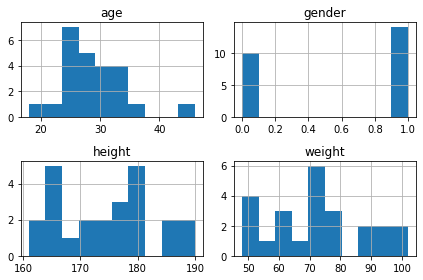

In [7]:
metadata.hist()
plt.tight_layout()

In [8]:
print('Dataset size:', len(dataset))

sample, _, _ = dataset[0]
print('Datapoints shape:', sample.shape)

Dataset size: 4095
Datapoints shape: (256, 12)


Our dataset is composed of 5205 datapoints, each have shape `(256, 12)` because we have 12 signals of 256 samples each.

For our base line model we will use the **user-acceleration magnitude**.
The x,y,z components of the feature are stored on the last 3 columns, se we'll take those and get the magnitude/norm:

In [9]:
X = np.array([np.hstack([np.linalg.norm(sample[:,-3:], axis=1)] + metadata) for sample, _, metadata in dataset])

In [10]:
X.shape

(4095, 260)

Now we "only" have 256 samples per datapoint.

Instead of directly using its value at each timestep, we will apply the Fourier transform and use the frequency domain as our input space.

In [11]:
X_fft = np.fft.fft(X[:,:256], axis=1)

print('Shape:', X_fft.shape)

Shape: (4095, 256)


The output of the Fourier transform is complex, we can take the norm to use real numbers. This will make it simetric so we can use only the positive frequencies.

In [12]:
X_fft = np.abs(np.fft.rfft(X, axis=1))

print('Shape:', X_fft.shape)

Shape: (4095, 131)


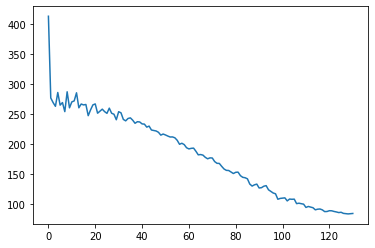

In [13]:
plt.plot(X_fft[7]);

### Classes

The classes are the following:

In [14]:
dataset.CLASSES

{'dws': 'down-stairs',
 'ups': 'up-stairs',
 'wlk': 'walk',
 'std': 'standing',
 'sit': 'sitting',
 'jog': 'jogging'}

In order to fit a `sklearn` model we should encode each class with a unique integer:

In [15]:
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(list(dataset.CLASSES.keys()));

In [16]:
y = label_encoder.transform([cls for _, cls, _ in dataset])

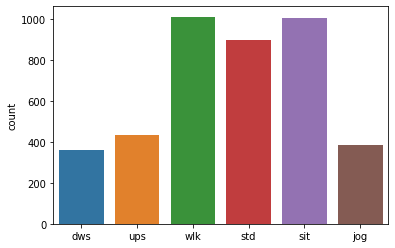

In [17]:
sns.countplot(label_encoder.inverse_transform(y));

#### Train-test splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [19]:
print('Number of training examples:', y_train.shape[0])
print('Number of testing examples:', y_test.shape[0])

Number of training examples: 2743
Number of testing examples: 1352


#### PCA feature reduction

In [20]:
pca = sklearn.pipeline.make_pipeline(
    FourierTransform(),
    # sklearn.preprocessing.StandardScaler(),
    PCA(n_components=32)
)

#### Join data with metadata

In [21]:
features = sklearn.compose.ColumnTransformer([
    ('fft_pca', pca, slice(0, -4)),
    ('metadata', 'passthrough', slice(-4, X.shape[1]))
])

## Visualization

In [22]:
X_feats = features.fit_transform(X_train)

In [23]:
X_feats.shape

(2743, 36)

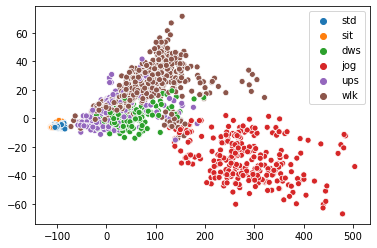

In [24]:
sns.scatterplot(x=X_feats[:,0], y=X_feats[:,1], hue=label_encoder.inverse_transform(y_train));

The classes seem VERY overlapped (except for the jog class), so the results are not promising.

## Quadratic Discriminant Analysis

In [25]:
import sklearn.discriminant_analysis

In [26]:
clf = sklearn.pipeline.make_pipeline(
    features,
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
)
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('fft_pca',
                                                  Pipeline(memory=None,
                                                           steps=[('fouriertransform',
                                                                   FourierTransform()),
                                                                  ('pca',
                                                                   PCA(copy=True,
                                                                       iterated_power='auto',
                                                                       n_components=32,
                                                                       random_state=None,
                    

In [27]:
print(classification_report(y_train, clf.predict(X_train), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.98      0.85      0.91       236
         jog       0.99      1.00      0.99       265
         sit       0.73      0.87      0.79       663
         std       0.83      0.63      0.72       615
         ups       0.71      0.96      0.82       298
         wlk       0.99      0.90      0.94       666

    accuracy                           0.84      2743
   macro avg       0.87      0.87      0.86      2743
weighted avg       0.86      0.84      0.84      2743



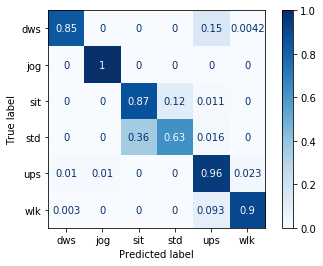

In [28]:
plot_confusion_matrix(clf, X_train, y_train,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")

In [29]:
print(classification_report(y_test, clf.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         dws       0.87      0.71      0.78       123
         jog       0.97      1.00      0.98       119
         sit       0.72      0.85      0.78       341
         std       0.77      0.58      0.66       285
         ups       0.67      0.90      0.77       138
         wlk       0.97      0.92      0.94       346

    accuracy                           0.82      1352
   macro avg       0.83      0.83      0.82      1352
weighted avg       0.82      0.82      0.81      1352



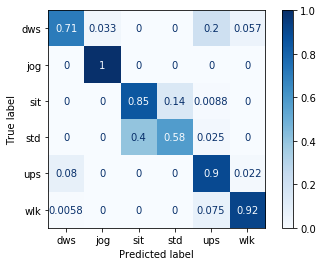

In [30]:
plot_confusion_matrix(clf, X_test, y_test,
                      display_labels=label_encoder.classes_,
                      cmap=plt.cm.Blues,
                      normalize="true")